# **Lung Opacity and COVID-19 Chest Radiography Classification and Detection by FasterRCNN with EfficientNet Backbone**

**Participants**
* **Dongha Kim** - Yonsei Univ. College of Medicine.
* **Junho Lee** - Yonsei Univ. Dept. of Computer Engineering.

---

## Description
X-ray photographs of representative lung diseases, Lung Opacity and COVID-19, will be classified as
deep learning, and patient disease will be classified with minimal Cost by detecting each disease site.
Correlation analysis of diseases according to gender age and correlation analysis and visualization
using various worldwide COVID-19 statistical indicators will be carried out.

---

## Datasets

**RSNA Pneumonia Detection Challenge Dataset**
* https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview

**COVID-19 Radiography Datset**
* https://www.kaggle.com/preetviradiya/covid19-radiography-dataset

---

## Model Architecture

**EfficientNet**
* https://arxiv.org/abs/1905.11946

**Faster-RCNN**
* https://arxiv.org/abs/1506.01497

---

**Train Script**
* See: train.py

**Full Source Code**
* See: https://github.com/kdha0727/lung-opacity-and-covid-chest-x-ray-detection

All non-necessary codes are modularized as package. Watch all codes in github repository.

---

# Preparations

## Data Mounting

In [1]:
# Check, with local module, whether runtime is colaboratory

try:  # local runtime
    import library_check
except ImportError:  # colab runtime
    library_check = None
    from google.colab import drive  # NOQA
    drive.mount('/content/drive')  # NOQA
    colaboratory = True
else:
    colaboratory = False

## Runtime Check

In [2]:
# System Information

import sys
import platform
print(f"OS version: \t\t{platform.platform()}\n"
      f"Python version:\t\t{sys.version}")

OS version: 		macOS-11.5.2-arm64-arm-64bit
Python version:		3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:27:18) 
[Clang 11.1.0 ]


In [3]:
# GPU Information

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0 or gpu_info.find('not found') >= 0:
    if colaboratory:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
else:
    print(gpu_info)

In [4]:
# Memory Information

try:
    from psutil import virtual_memory  # NOQA
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if colaboratory:
        if ram_gb < 20:
            print('To enable a high-RAM runtime, select the Runtime > "Change runtime type" '
                  'menu, and then select High-RAM in the Runtime shape dropdown. Then, '
                  're-execute this cell.')
        else:
            print('You are using a high-RAM runtime!')
except ImportError:
    pass

Your runtime has 17.2 gigabytes of available RAM



## Library Installation

In [5]:
# Install required libraries

if colaboratory:  # colab runtime
    !git clone https://github.com/kdha0727/lung-opacity-and-covid-chest-x-ray-detection/
    %cd lung-opacity-and-covid-chest-x-ray-detection
    !pip install -r requirements.txt
    import library_check
    library_check.check()
    import os
    root = ""
    while not os.path.isdir(root):
        root = input("Enter your data dir in shared drives: ")
    import data_prep_utils
    data_prep_utils.set_root(root)
else:  # local runtime
    library_check.check()
    import data_prep_utils
data_prep_utils.init()

All required libraries are installed.


In [6]:
# After all installation, import all libraries used.

import inspect
import random
import pydicom as dcm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchinfo

In [7]:
# And, import custom-defined Lazy Data Wrappers and Utilities

from data_prep_utils import covid_19_radiography_dataset
from data_prep_utils import rsna_pneumonia_detection_challenge

import models

# Data Analysis and Processing

* Note: All preprocessing processes are modularized as "Data Wrapper" package

**Class Information**
* Normal: 0
* Lung Opacity: 1
* COVID-19: 2
* Viral Pneumonia: 3

In [8]:
print('\n\t'.join(map(str, ['Labels: (', *covid_19_radiography_dataset.class_to_idx.items()])), '\n)')

Labels: (
	('Normal', 0)
	('Lung_Opacity', 1)
	('COVID', 2)
	('Viral Pneumonia', 3) 
)


## **First Dataset: COVID-19 Radiography Dataset**

**Raw CSV Files**

In [9]:
df_metadata = covid_19_radiography_dataset.metadata_csv
df_metadata

,file_name,file_format,image_shape,label,Target
0,COVID-1.png,PNG,"(299, 299)",COVID,2
1,COVID-10.png,PNG,"(299, 299)",COVID,2
2,COVID-100.png,PNG,"(299, 299)",COVID,2
3,COVID-1000.png,PNG,"(299, 299)",COVID,2
4,COVID-1001.png,PNG,"(299, 299)",COVID,2
...,...,...,...,...,...
21160,Viral Pneumonia-995.png,PNG,"(299, 299)",Viral Pneumonia,3
21161,Viral Pneumonia-996.png,PNG,"(299, 299)",Viral Pneumonia,3
21162,Viral Pneumonia-997.png,PNG,"(299, 299)",Viral Pneumonia,3
21163,Viral Pneumonia-998.png,PNG,"(299, 299)",Viral Pneumonia,3


**Target Distribution**

<AxesSubplot:xlabel='label', ylabel='count'>

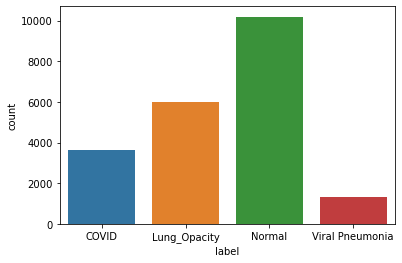

In [10]:
sns.countplot(x=df_metadata["label"])

## **Second Dataset: RSNA Pneumonia Detection Challenge**

**Raw CSV Files**

In [11]:
df_train_labels = rsna_pneumonia_detection_challenge.train_labels_csv
df_train_labels

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [12]:
df_class_info = rsna_pneumonia_detection_challenge.class_info_csv
df_class_info

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


**Concatenated and Deduplicated CSV**

In [13]:
df_full = rsna_pneumonia_detection_challenge.full_csv
df_full

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,570.0,393.0,261.0,345.0,1


**Target Distribution**
* 0 is normal, 1 is Lung Opacity.

<AxesSubplot:xlabel='Target', ylabel='count'>

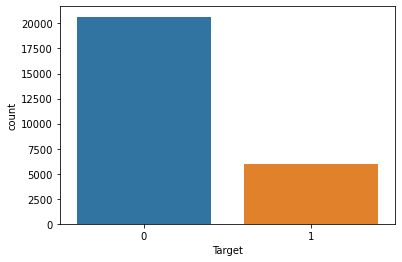

In [14]:
sns.countplot(x=df_train_labels[["patientId", "Target"]].drop_duplicates()['Target'])

**Detailed class Distribution**
* Note: "No Lung Opacity / Not Normal" class is regarded as Normal(0).

<AxesSubplot:xlabel='class', ylabel='count'>

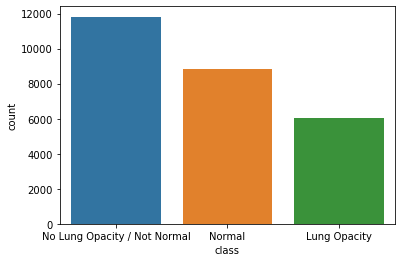

In [15]:
sns.countplot(x=df_class_info[["patientId", "class"]].drop_duplicates()['class'])

**Bounding Box Distribution**

In [16]:
df_lung_opacity = rsna_pneumonia_detection_challenge.lung_opacity_csv
df_lung_opacity

,patientId,class,x,y,width,height,Target
0,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
1,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
2,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,323.0,577.0,160.0,104.0,1
3,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity,695.0,575.0,162.0,137.0,1
4,00aecb01-a116-45a2-956c-08d2fa55433f,Lung Opacity,288.0,322.0,94.0,135.0,1
...,...,...,...,...,...,...,...
9550,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity,316.0,504.0,179.0,273.0,1
9551,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,609.0,464.0,240.0,284.0,1
9552,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,185.0,298.0,228.0,379.0,1
9553,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity,570.0,393.0,261.0,345.0,1


<AxesSubplot:xlabel='x', ylabel='count'>

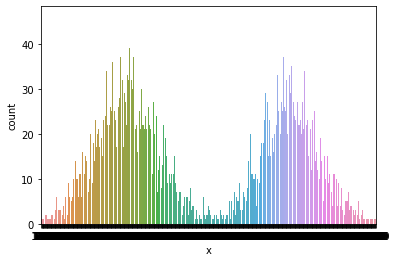

In [17]:
sns.countplot(x=df_lung_opacity['x'])

<AxesSubplot:xlabel='y', ylabel='count'>

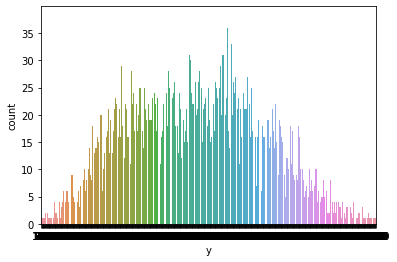

In [18]:
sns.countplot(x=df_lung_opacity['y'])

**Dicom File: Metadata and Image**

In [19]:
rd_path = rsna_pneumonia_detection_challenge.get_random_patient_id()
rd_path = rsna_pneumonia_detection_challenge.get_patient_path(rd_path)

In [20]:
metadata = dcm.dcmread(rd_path)
metadata

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28086.1517874483.179431
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28086.1517874483.179431
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

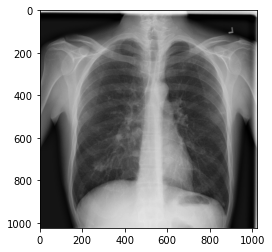

In [21]:
plt.imshow(metadata.pixel_array, cmap=plt.cm.gray)  # type: ignore
plt.show()

**Bounding Box**

In [22]:
getPatientPath = rsna_pneumonia_detection_challenge.get_patient_path


def bbox_to_rect(bbox, color):  # bbox = (x1,y1,x2,y2) = (x,y,w+x,h+y)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1],
        fill=False, edgecolor=color, linewidth=1
    )


def box_image_from_dataset(patient_id):
    fig = plt.imshow(dcm.dcmread(getPatientPath(patient_id)).pixel_array, cmap=plt.cm.gray)  # type: ignore
    df = df_lung_opacity[df_lung_opacity['patientId'] == patient_id]
    for _, (x, y, w, h) in df[['x', 'y', 'width', 'height']].iterrows():
        fig.axes.add_patch(bbox_to_rect([x, y, x+w, y+h], 'b'))
    plt.show()


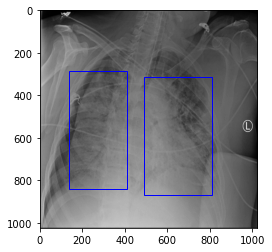

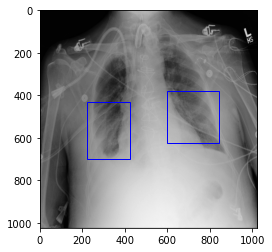

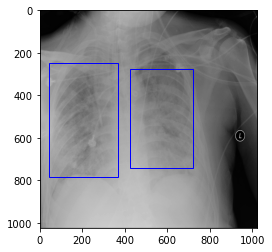

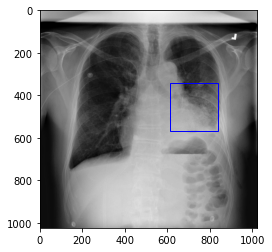

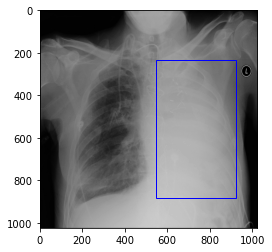

{None}

In [23]:
{*map(box_image_from_dataset, random.choices([*{*df_lung_opacity['patientId']}], k=5))}

**Number of Bounding Box per Patients**

In [24]:
df_n_box = df_lung_opacity.groupby('patientId').size().reset_index(name='boxes')
df_n_box.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,2614
1,2,3266
2,3,119
3,4,13


<AxesSubplot:xlabel='boxes', ylabel='count'>

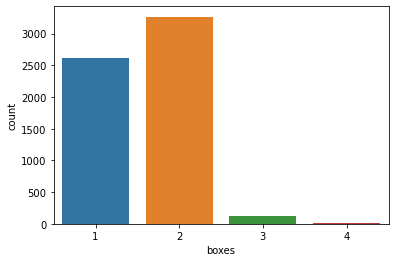

In [25]:
sns.countplot(x=df_n_box['boxes'])

**Bounding Box Distribution**

<AxesSubplot:xlabel='x', ylabel='y'>

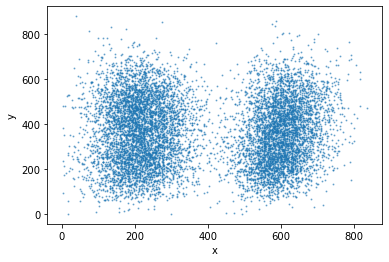

In [26]:
df_lung_opacity.plot.scatter(x='x', y='y', alpha=0.5, s=1)

# Modeling via PyTorch

## Model Architecture

**Backbone: EfficientNet**
* https://arxiv.org/abs/1905.11946

**Detector: Faster-RCNN**
* https://arxiv.org/abs/1506.01497

**Classifier: FCN**

In [27]:
efficientnet_backbone = models.efficientnet.get_efficientnet_backbone(
    depth=4, in_channels=1, image_size=256, pretrained=False
)

In [28]:
class Classifier(torch.nn.Module):

    def __init__(self, backbone, num_classes, out_channels=None, dropout_rate=0.4):
        super().__init__()
        out_channels = out_channels or backbone.out_channels
        self.feature_extractor = backbone
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(out_channels, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


def get_classifier(backbone, num_classes=4):
    return Classifier(backbone, num_classes)


In [29]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform


def get_detector(backbone, num_classes=2, max_size=800, min_size=1333, **kwargs):

    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    detector = FasterRCNN(backbone, num_classes, rpn_anchor_generator=anchor_generator, **kwargs)
    detector.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean=[0.485], image_std=[0.229])
    return detector

In [30]:
torchinfo.summary(efficientnet_backbone, [1, 1, 256, 256])

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       --                        --
├─ModuleList: 1-1                                  --                        --
├─Conv2dStaticSamePadding: 1-2                     [1, 48, 128, 128]         --
│    └─ZeroPad2d: 2-1                              [1, 1, 257, 257]          --
├─BatchNorm2d: 1-3                                 [1, 48, 128, 128]         96
├─MemoryEfficientSwish: 1-4                        [1, 48, 128, 128]         --
├─ModuleList: 1-1                                  --                        --
│    └─MBConvBlock: 2-2                            [1, 24, 128, 128]         --
│    │    └─Conv2dStaticSamePadding: 3-1           [1, 48, 128, 128]         432
│    │    └─BatchNorm2d: 3-2                       [1, 48, 128, 128]         96
│    │    └─MemoryEfficientSwish: 3-3              [1, 48, 128, 128]         --
│    │    └─Conv2dStaticSamePaddin

## Data Augmentation

**Transforms: albumentations**

In [31]:
print("Classification transforms:")
print(data_prep_utils.transforms.get_classification_train_transforms())

Classification transforms:
Compose(
    ToTensor()
    Normalize(mean=(0.45,), std=(0.225,))
    Resize(size=256, interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
)


In [32]:
print("Detection transforms:")
print(data_prep_utils.transforms.get_detection_train_transforms())

Detection transforms:
Compose([
  Normalize(always_apply=False, p=1.0, mean=(0.45,), std=(0.225,), max_pixel_value=255.0),
  RandomBrightnessContrast(always_apply=False, p=0.9, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  HorizontalFlip(always_apply=False, p=0.5),
  Resize(always_apply=False, p=1, height=256, width=256, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0, 'min_visibility': 0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})


**Data Resampling: Imbalanced Data Sampler**

In [33]:
print(inspect.getsource(data_prep_utils.samplers.ImbalancedDatasetSampler))

class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """
    Samples elements randomly from a given list of indices for imbalanced dataset

    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices: list = None, num_samples: int = None, callback_get_label: Callable = None):  # NOQA

        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = (callback_get_label or self._get_labels)(dataset)
        df.index = sel

## Dataset Implementation

Dataset Class Source Code

In [34]:
print(inspect.getsource(data_prep_utils.dataset.ImageBboxWithPandas))
print(inspect.getsource(data_prep_utils.dataset.ImageFolder))

class ImageBboxWithPandas(VisionDataset):
    """A generic data loader where the image path and label is given as pandas DataFrame.

    Args:
        dataframe (pandas.DataFrame): A data table that contains image path, target class,
            and extra outputs.
        label_id (string): Data frame`s image path label string.
        label_target (string): Data frame`s target class label string.
        label_bbox (tuple[string] or string, optional): Data frame`s label that will
            be used for bbox outputs.
        root (string, optional): Root directory path. Use unless data frame`s column
            contains file folders.
        extension (string, optional): An extension that will be concatenated after
            image file name. Use unless data frame`s column contains extension.
        class_to_idx (dict[str, int], optional): A mapping table that converts class
            label string into integer value. If not given, sorted index value will
            be used as cl

In [35]:
print(inspect.getsource(data_prep_utils.dataset.DataLoaderChain))

class DataLoaderChain(IterableDataset):

    __loaders: tuple = ()
    __length: int = 0

    def __init__(self, *loaders):
        self.loaders = loaders

    @classmethod
    def from_datasets(cls, *datasets, **loader_kwargs):
        return cls(*(DataLoader(dataset, **loader_kwargs) for dataset in datasets))

    @property
    def loaders(self):
        return self.__loaders

    @loaders.setter
    def loaders(self, value):
        if not isinstance(value, tuple):
            raise TypeError(str(type(value).__name__))
        self.__loaders = value
        self.__length = sum((map(len, value)))

    @property
    def length(self):
        return self.__length

    def __iter__(self):
        available = [iter(loader) for loader in self.loaders]
        len_available = len(available)
        while True:
            idx = random.randrange(len_available)
            try:
                yield next(available[idx])
            except StopIteration:
                available.pop(idx)
   

# Training

## Train Script Implementation

In [36]:
import train as train_script
print(inspect.getsource(train_script.train))

def train(args):

    import library_check
    library_check.check(raise_exception=True)

    import data_prep_utils
    import models
    import train_utils
    if args.data_dir:
        data_prep_utils.set_root(args.data_dir)
    data_prep_utils.init()

    import torch

    opt = dict(num_workers=args.num_workers, pin_memory=args.pin_memory)

    train_data_cls_1 = data_prep_utils.rsna_pneumonia_detection_challenge.torch_classification_dataset(
        data_prep_utils.transforms.get_classification_train_transforms())
    train_loader_cls_1 = torch.utils.data.DataLoader(  # type: ignore
        train_data_cls_1,
        sampler=data_prep_utils.samplers.ImbalancedDatasetSampler(train_data_cls_1),
        batch_size=args.classification_batch_size, **opt
    )

    train_data_cls_2 = data_prep_utils.covid_19_radiography_dataset.torch_classification_dataset(
        data_prep_utils.transforms.get_classification_train_transforms())
    train_loader_cls_2 = torch.utils.data.DataLoader(  # 

In [37]:
print(train_script.parser.format_help())

usage: train.py [-h] [--epoch EPOCH]
                [--classification_batch_size CLASSIFICATION_BATCH_SIZE]
                [--detection_batch_size DETECTION_BATCH_SIZE]
                [--num_workers NUM_WORKERS] [--log_interval LOG_INTERVAL]
                [--device DEVICE] [--pin_memory] [--data_dir DATA_DIR]
                [--checkpoint_dir CHECKPOINT_DIR] [--save_model]
                [--save_path SAVE_PATH]

Script for Pytorch Model Training.

optional arguments:
  -h, --help            show this help message and exit
  --epoch EPOCH         How many epochs to train (default: 100)
  --classification_batch_size CLASSIFICATION_BATCH_SIZE
                        How many batches used in classification training
                        (default: 32)
  --detection_batch_size DETECTION_BATCH_SIZE
                        How many batches used in detection training (default:
                        3)
  --num_workers NUM_WORKERS
                        The number of dataloader work pr

## Running train script and load weights

In [38]:
weight_path = 'checkpoint/model_weight.pt'

if colaboratory:
    !python train.py --data_dir $root --save_model --save_path $weight_path
else:
    !python train.py --save_model --save_path $weight_path

In [ ]:
# Load weights

model_c = get_classifier(efficientnet_backbone)
model_d = get_detector(efficientnet_backbone)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight = torch.load(weight_path)

model_c.eval().requires_grad_(False).to(device).load_state_dict(weight['classifier'])
model_d.eval().requires_grad_(False).to(device).load_state_dict(weight['detector'])

print("Successfully loaded weights.")

# Performance Visualization

## Classification Confusion Matrix

In [ ]:
data_covid_cls = covid_19_radiography_dataset.torch_classification_dataset(
    data_prep_utils.transforms.get_classification_valid_transforms(), batch_size=32)
data_rsna_cls = rsna_pneumonia_detection_challenge.torch_classification_dataset(
    data_prep_utils.transforms.get_classification_valid_transforms(), batch_size=32)

cm_covid = models.metrics.classification_confusion_matrix(model_c, data_covid_cls, device)
cm_rsna = models.metrics.classification_confusion_matrix(model_c, data_rsna_cls, device)

group_names = list(covid_19_radiography_dataset.class_to_idx.keys())

In [ ]:
print("COVID-19 Radiography Dataset Classification Confusion Matrix")
models.metrics.draw_confusion_matrix(cm_covid, group_names=group_names, figsize=(10, 8))

In [ ]:
print("RSNA Pneumonia Detection Challenge Dataset Classification Confusion Matrix")
models.metrics.draw_confusion_matrix(cm_rsna[:2, :2], group_names=group_names[:2], figsize=(10, 8))

In [ ]:
print("Summary")
models.metrics.draw_confusion_matrix(cm_rsna + cm_covid, group_names=group_names, figsize=(10, 8))

## Detection Proposal

In [ ]:
def box_image_from_model_output(image, output, detection_threshold=0.22, ax=None):

    if image.ndim == 4:
        return [box_image_from_model_output(im, op, detection_threshold, ax=None) for im, op in zip(image, output)]

    image = image[0].cpu().numpy()
    boxes = output['boxes'].data.cpu().numpy() \
        [output['scores'].data.cpu().numpy() >= detection_threshold] \
        .astype(int)

    if ax is not None:
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
    fig = ax.imshow(image, cmap=plt.cm.gray)  # NOQA
    for x, y, xw, yh in boxes:
        fig.axes.add_patch(bbox_to_rect([x, y, xw, yh], 'b'))

    return fig

In [ ]:
data_rsna_det = rsna_pneumonia_detection_challenge.torch_detection_dataset(
    data_prep_utils.transforms.get_detection_valid_transforms())

with torch.no_grad():

    iterator = iter(data_rsna_det)

    fig = plt.figure(figsize=(10, 8))
    plt.xticks([])
    plt.yticks([])
    plt.title("Lung Opacity Detection Example")

    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        dataset = next(iterator)
        image = dataset['image'].to(device).float()
        boxes = dataset['boxes'].to(device).float()
        output = model_d(image)
        box_image_from_model_output(image, output, ax=ax)

    plt.show()